# Transcript to silence vector: Application

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
from glob import glob
import os
from matplotlib.pylab import *
import librosa
import torch
from epoch_time import epoch_time
from tqdm.notebook import tqdm
from OpenASR_convert_reference_transcript import txt_to_stm
import pandas as pd
import numpy as np
from padarray import padarray
from to_samples import to_samples
from torch.utils.data import TensorDataset, DataLoader
import audioread
import random
import soundfile as sf
import math
from to_segments import to_segments
from running_mean import running_mean

In [4]:
stage='NIST'
sample_rate=8000
window = sample_rate
H=window

In [5]:
transcripts = list(sorted(glob(f'{stage}/*/build/transcription/*.txt')))
len(transcripts)

122

In [6]:
audio_files=[x.replace('/transcription/', '/audio/').replace('.txt','.wav') for x in transcripts]

In [7]:
transcript_file = transcripts[0]
transcript_file

'NIST/openasr20_amharic/build/transcription/BABEL_OP3_307_14229_20140503_233516_inLine.txt'

In [9]:
audio_file = transcript_file.replace('/transcription/', '/audio/').replace('.txt','.wav')
file = "_".join(os.path.basename(transcript_file).split("_")[:-1])
channel = os.path.basename(transcript_file).split("_")[-1].split(".")[-2]
transcript_df = pd.read_csv(transcript_file, sep = "\n", header = None, names = ["content"])
transcript = txt_to_stm(transcript_df, file, channel)
silences=[(float(x[-2]), float(x[-1])) for x in transcript if len(x)==5]
x_np,sr=librosa.load(audio_file, sr=sample_rate)
recording_length=x_np.shape[0]
silence_segments=[(int(a*sample_rate), int(b*sample_rate)) for (a,b) in silences]
y_np=np.zeros(recording_length,dtype=x_np.dtype)
for lower, upper in silence_segments:
    y_np[lower:upper]=1

In [15]:
x_samples_np=to_segments(x_np, window)
y_samples_np=to_segments(y_np, window)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
tensor_x = torch.Tensor(x_samples_np).to(device)

In [24]:
D_in,D_out=window,window
D_in,H,D_out

(8000, 8000, 8000)

In [25]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU()
).cuda()

In [26]:
model_fn='silence_detector.pt'
model.load_state_dict(torch.load(model_fn))

<All keys matched successfully>

In [39]:
with torch.no_grad():
    y_pred_cuda=model(tensor_x)

In [123]:
y_pred = np.reshape(y_pred_cuda.cpu().numpy(), -1)
y_pred = running_mean(y_pred, 500)[0:y_np.shape[0]]
y_pred = (y_pred > 0.5).astype(float)

In [124]:
frame=sample_rate*120

(71.0, 88.0)

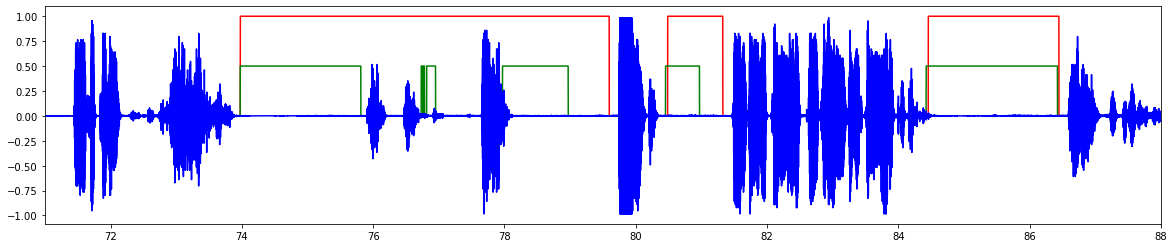

In [125]:
figure(figsize=(20,4))
T=np.arange(frame)/sample_rate
plot(T,y_np[0:frame], color='red')
plot(T,0.5*y_pred[0:frame], color='green')
plot(T,x_np[0:frame], color='blue');
xlim(71,88)

In [126]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_np, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   2388159
         1.0       0.99      0.88      0.93   2412001

    accuracy                           0.94   4800160
   macro avg       0.94      0.94      0.94   4800160
weighted avg       0.94      0.94      0.94   4800160



In [127]:
labels = ['speech', 'silence']
cm = confusion_matrix(y_np, y_pred)

In [131]:
100*(cm/2388159)

array([[99.50024266,  0.49975734],
       [12.49904215, 88.49930009]])

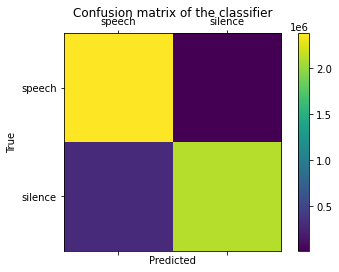

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()